In [98]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Load population data
population_df = pd.read_csv('./data/england_population.csv')
print("Population data loaded:")
print(population_df.head())
print(f"Population data shape: {population_df.shape}")

Population data loaded:
       year annual_population_change
0  Mid-1949                  299,000
1  Mid-1950                  235,000
2  Mid-1951                  -15,000
3  Mid-1952                  140,000
4  Mid-1953                  154,000
Population data shape: (76, 2)


In [100]:
# Load migration data with proper CSV parsing
try:
    migration_df = pd.read_csv('./data/eu_noneu.csv', quotechar='"', skipinitialspace=True)
    print("Migration data loaded with quote handling:")
    print(migration_df.head())
except:
    # If that doesn't work, try manual parsing
    print("Standard CSV loading failed, trying manual approach...")
    
    # Read the file manually and clean it
    with open('./data/eu_noneu.csv', 'r') as f:
        lines = f.readlines()
    
    # Clean the lines
    cleaned_lines = []
    for line in lines:
        # Remove the outer quotes and clean up
        cleaned_line = line.strip().replace('", "', '","').replace('"', '')
        cleaned_lines.append(cleaned_line)
    
    # Write to a temporary clean file in memory
    from io import StringIO
    clean_csv = StringIO('\n'.join(cleaned_lines))
    migration_df = pd.read_csv(clean_csv)

print(f"Migration data shape: {migration_df.shape}")
print(f"Migration columns: {migration_df.columns.tolist()}")
print("\nFirst few rows:")
print(migration_df.head())

Migration data loaded with quote handling:
      Period Non-EU+      EU+  British    Total
0  YE Jun 12  57,000  187,000  -83,000  162,000
1  YE Sep 12  54,000  183,000  -80,000  157,000
2  YE Dec 12  61,000  206,000  -72,000  195,000
3  YE Mar 13  60,000  223,000  -79,000  204,000
4  YE Jun 13  56,000  242,000  -83,000  215,000
Migration data shape: (51, 5)
Migration columns: ['Period', 'Non-EU+', 'EU+', 'British', 'Total']

First few rows:
      Period Non-EU+      EU+  British    Total
0  YE Jun 12  57,000  187,000  -83,000  162,000
1  YE Sep 12  54,000  183,000  -80,000  157,000
2  YE Dec 12  61,000  206,000  -72,000  195,000
3  YE Mar 13  60,000  223,000  -79,000  204,000
4  YE Jun 13  56,000  242,000  -83,000  215,000


In [101]:
# Clean column names if needed
migration_df.columns = [col.strip() for col in migration_df.columns]
print("Column names after cleaning:")
print(migration_df.columns.tolist())

# Check the actual data structure
print("\nSample data values:")
print(migration_df.iloc[0])
print("\nData types:")
print(migration_df.dtypes)

Column names after cleaning:
['Period', 'Non-EU+', 'EU+', 'British', 'Total']

Sample data values:
Period     YE Jun 12
Non-EU+       57,000
EU+          187,000
British      -83,000
Total        162,000
Name: 0, dtype: object

Data types:
Period     object
Non-EU+    object
EU+        object
British    object
Total      object
dtype: object


In [102]:
# Extract years properly from the Period column with improved regex
migration_df['Period'] = migration_df['Period'].astype(str).str.strip()

def extract_year_from_period(period_str):
    """Extract year from period string like 'YE Jun 12' or 'YE Dec 23 R' -> 2012, 2023"""
    import re
    
    period_str = str(period_str).strip()
    
    # Look for 2 digits that come after a space, followed by optional letters
    # This handles cases like "YE Jun 12", "YE Dec 23 R", "YE Mar 24 P R"
    match = re.search(r'\s(\d{2})(?:\s|$)', period_str)
    if match:
        year_2digit = int(match.group(1))
        # Convert 2-digit year to 4-digit
        # Assume 12-24 is 2012-2024, others are 19xx or 20xx based on context
        if year_2digit >= 12 and year_2digit <= 24:
            return year_2digit + 2000
        elif year_2digit >= 0 and year_2digit <= 11:
            return year_2digit + 2000
        else:
            return year_2digit + 1900
    
    return None

# Apply improved year extraction
migration_df['year'] = migration_df['Period'].apply(extract_year_from_period)

print("Improved year extraction results:")
print(migration_df[['Period', 'year']].head(10))
print(migration_df[['Period', 'year']].tail(10))
print(f"\nYear range: {migration_df['year'].min()} - {migration_df['year'].max()}")
print(f"Unique years: {sorted(migration_df['year'].dropna().unique())}")

Improved year extraction results:
      Period  year
0  YE Jun 12  2012
1  YE Sep 12  2012
2  YE Dec 12  2012
3  YE Mar 13  2013
4  YE Jun 13  2013
5  YE Sep 13  2013
6  YE Dec 13  2013
7  YE Mar 14  2014
8  YE Jun 14  2014
9  YE Sep 14  2014
           Period  year
41      YE Sep 22  2022
42      YE Dec 22  2022
43      YE Mar 23  2023
44      YE Jun 23  2023
45      YE Sep 23  2023
46    YE Dec 23 R  2023
47  YE Mar 24 P R  2024
48  YE Jun 24 P R  2024
49    YE Sep 24 P  2024
50    YE Dec 24 P  2024

Year range: 2012 - 2024
Unique years: [np.int64(2012), np.int64(2013), np.int64(2014), np.int64(2015), np.int64(2016), np.int64(2017), np.int64(2018), np.int64(2019), np.int64(2020), np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024)]


In [103]:
# Clean the migration value columns
value_cols = ['Non-EU+', 'EU+', 'British', 'Total']

print("Before cleaning - sample values:")
for col in value_cols:
    if col in migration_df.columns:
        print(f"{col}: '{migration_df[col].iloc[0]}'")

# Clean each column
for col in value_cols:
    if col in migration_df.columns:
        # Convert to string, remove commas, and handle numeric conversion
        migration_df[col] = (migration_df[col]
                            .astype(str)
                            .str.replace(',', '')
                            .str.strip())
        
        # Convert to numeric
        migration_df[col] = pd.to_numeric(migration_df[col], errors='coerce')

print("\nAfter cleaning - sample values:")
for col in value_cols:
    if col in migration_df.columns:
        print(f"{col}: {migration_df[col].iloc[0]}")

print("\nCleaned migration data sample:")
available_cols = ['Period', 'year'] + [col for col in value_cols if col in migration_df.columns]
print(migration_df[available_cols].head())
print(migration_df[available_cols].tail())

Before cleaning - sample values:
Non-EU+: '57,000'
EU+: '187,000'
British: '-83,000'
Total: '162,000'

After cleaning - sample values:
Non-EU+: 57000
EU+: 187000
British: -83000
Total: 162000

Cleaned migration data sample:
      Period  year  Non-EU+     EU+  British   Total
0  YE Jun 12  2012    57000  187000   -83000  162000
1  YE Sep 12  2012    54000  183000   -80000  157000
2  YE Dec 12  2012    61000  206000   -72000  195000
3  YE Mar 13  2013    60000  223000   -79000  204000
4  YE Jun 13  2013    56000  242000   -83000  215000
           Period  year  Non-EU+    EU+  British   Total
46    YE Dec 23 R  2023   952000 -55000   -37000  860000
47  YE Mar 24 P R  2024   927000 -85000   -17000  825000
48  YE Jun 24 P R  2024   856000 -95000   -21000  739000
49    YE Sep 24 P  2024   709000 -86000   -21000  601000
50    YE Dec 24 P  2024   544000 -96000   -17000  431000


In [104]:
# Clean population data
population_df['annual_population_change'] = (population_df['annual_population_change']
                                            .str.replace(',', '')
                                            .astype(float))
population_df['year'] = (population_df['year']
                        .str.replace('Mid-', '')
                        .astype(int))

print("Cleaned population data:")
print(population_df.head())

Cleaned population data:
   year  annual_population_change
0  1949                  299000.0
1  1950                  235000.0
2  1951                  -15000.0
3  1952                  140000.0
4  1953                  154000.0


In [105]:
# Check records per year and look for 2020-2024 data
year_counts = migration_df['year'].value_counts().sort_index()
print("Records per year:")
print(year_counts.tail(15))

# Look for 2020-2024 data
recent_data = migration_df[migration_df['year'] >= 2020]
print(f"\nMigration data for 2020-2024: {len(recent_data)} records")

if len(recent_data) > 0:
    available_cols = ['Period', 'year'] + [col for col in value_cols if col in migration_df.columns]
    print("2020-2024 migration data:")
    print(recent_data[available_cols])
else:
    print("No data found for 2020-2024")

Records per year:
year
2012    3
2013    4
2014    4
2015    4
2016    4
2017    4
2018    4
2019    4
2020    4
2021    4
2022    4
2023    4
2024    4
Name: count, dtype: int64

Migration data for 2020-2024: 20 records
2020-2024 migration data:
           Period  year  Non-EU+     EU+  British   Total
31      YE Mar 20  2020   166000   81000   -77000  170000
32      YE Jun 20  2020   115000   70000   -74000  111000
33      YE Sep 20  2020    60000   45000   -70000   35000
34      YE Dec 20  2020   101000   70000   -78000   93000
35      YE Mar 21  2021   150000   61000   -79000  132000
36      YE Jun 21  2021   251000   75000   -73000  254000
37      YE Sep 21  2021   441000   12000    14000  467000
38      YE Dec 21  2021   529000  -77000    32000  484000
39      YE Mar 22  2022   640000 -122000    29000  548000
40      YE Jun 22  2022   754000 -140000    20000  634000
41      YE Sep 22  2022   902000 -119000     6000  789000
42      YE Dec 22  2022   965000  -88000    -4000  873000

In [106]:
# Filter for 2020-2024 data
population_2020_2024 = population_df[population_df['year'] >= 2020].copy()
migration_2020_2024 = migration_df[migration_df['year'] >= 2020].copy()

print("Population 2020-2024:")
print(population_2020_2024)

print(f"\nMigration 2020-2024 ({len(migration_2020_2024)} records):")
available_cols = ['Period', 'year'] + [col for col in value_cols if col in migration_df.columns]
print(migration_2020_2024[available_cols])

Population 2020-2024:
    year  annual_population_change
71  2020                  112656.0
72  2021                  230080.0
73  2022                  618067.0
74  2023                  821210.0
75  2024                  706881.0

Migration 2020-2024 (20 records):
           Period  year  Non-EU+     EU+  British   Total
31      YE Mar 20  2020   166000   81000   -77000  170000
32      YE Jun 20  2020   115000   70000   -74000  111000
33      YE Sep 20  2020    60000   45000   -70000   35000
34      YE Dec 20  2020   101000   70000   -78000   93000
35      YE Mar 21  2021   150000   61000   -79000  132000
36      YE Jun 21  2021   251000   75000   -73000  254000
37      YE Sep 21  2021   441000   12000    14000  467000
38      YE Dec 21  2021   529000  -77000    32000  484000
39      YE Mar 22  2022   640000 -122000    29000  548000
40      YE Jun 22  2022   754000 -140000    20000  634000
41      YE Sep 22  2022   902000 -119000     6000  789000
42      YE Dec 22  2022   965000  -88

In [107]:
# Create annual averages for migration (quarterly to annual)
if len(migration_2020_2024) > 0:
    available_value_cols = [col for col in value_cols if col in migration_df.columns]
    migration_annual = migration_2020_2024.groupby('year')[available_value_cols].mean().reset_index()
    
    print("Annual migration averages (2020-2024):")
    print(migration_annual)
else:
    print("No migration data available for 2020-2024")
    migration_annual = pd.DataFrame()

Annual migration averages (2020-2024):
   year   Non-EU+       EU+  British     Total
0  2020  110500.0   66500.0 -74750.0  102250.0
1  2021  342750.0   17750.0 -26500.0  334250.0
2  2022  815250.0 -117250.0  12750.0  711000.0
3  2023  955000.0  -50250.0 -21750.0  883000.0
4  2024  759000.0  -90500.0 -19000.0  649000.0


In [108]:
# Merge the datasets
if len(migration_annual) > 0 and len(population_2020_2024) > 0:
    combined_df = pd.merge(population_2020_2024, migration_annual, on='year', how='inner')
    
    print("Combined dataset:")
    print(combined_df)
    print(f"Combined dataset shape: {combined_df.shape}")
    
    if len(combined_df) > 0:
        print("SUCCESS: Data successfully combined!")
    else:
        print("ERROR: No data after merging!")
else:
    print("ERROR: Cannot merge - insufficient data")
    combined_df = pd.DataFrame()

Combined dataset:
   year  annual_population_change   Non-EU+       EU+  British     Total
0  2020                  112656.0  110500.0   66500.0 -74750.0  102250.0
1  2021                  230080.0  342750.0   17750.0 -26500.0  334250.0
2  2022                  618067.0  815250.0 -117250.0  12750.0  711000.0
3  2023                  821210.0  955000.0  -50250.0 -21750.0  883000.0
4  2024                  706881.0  759000.0  -90500.0 -19000.0  649000.0
Combined dataset shape: (5, 6)
SUCCESS: Data successfully combined!


<Figure size 1600x1200 with 0 Axes>

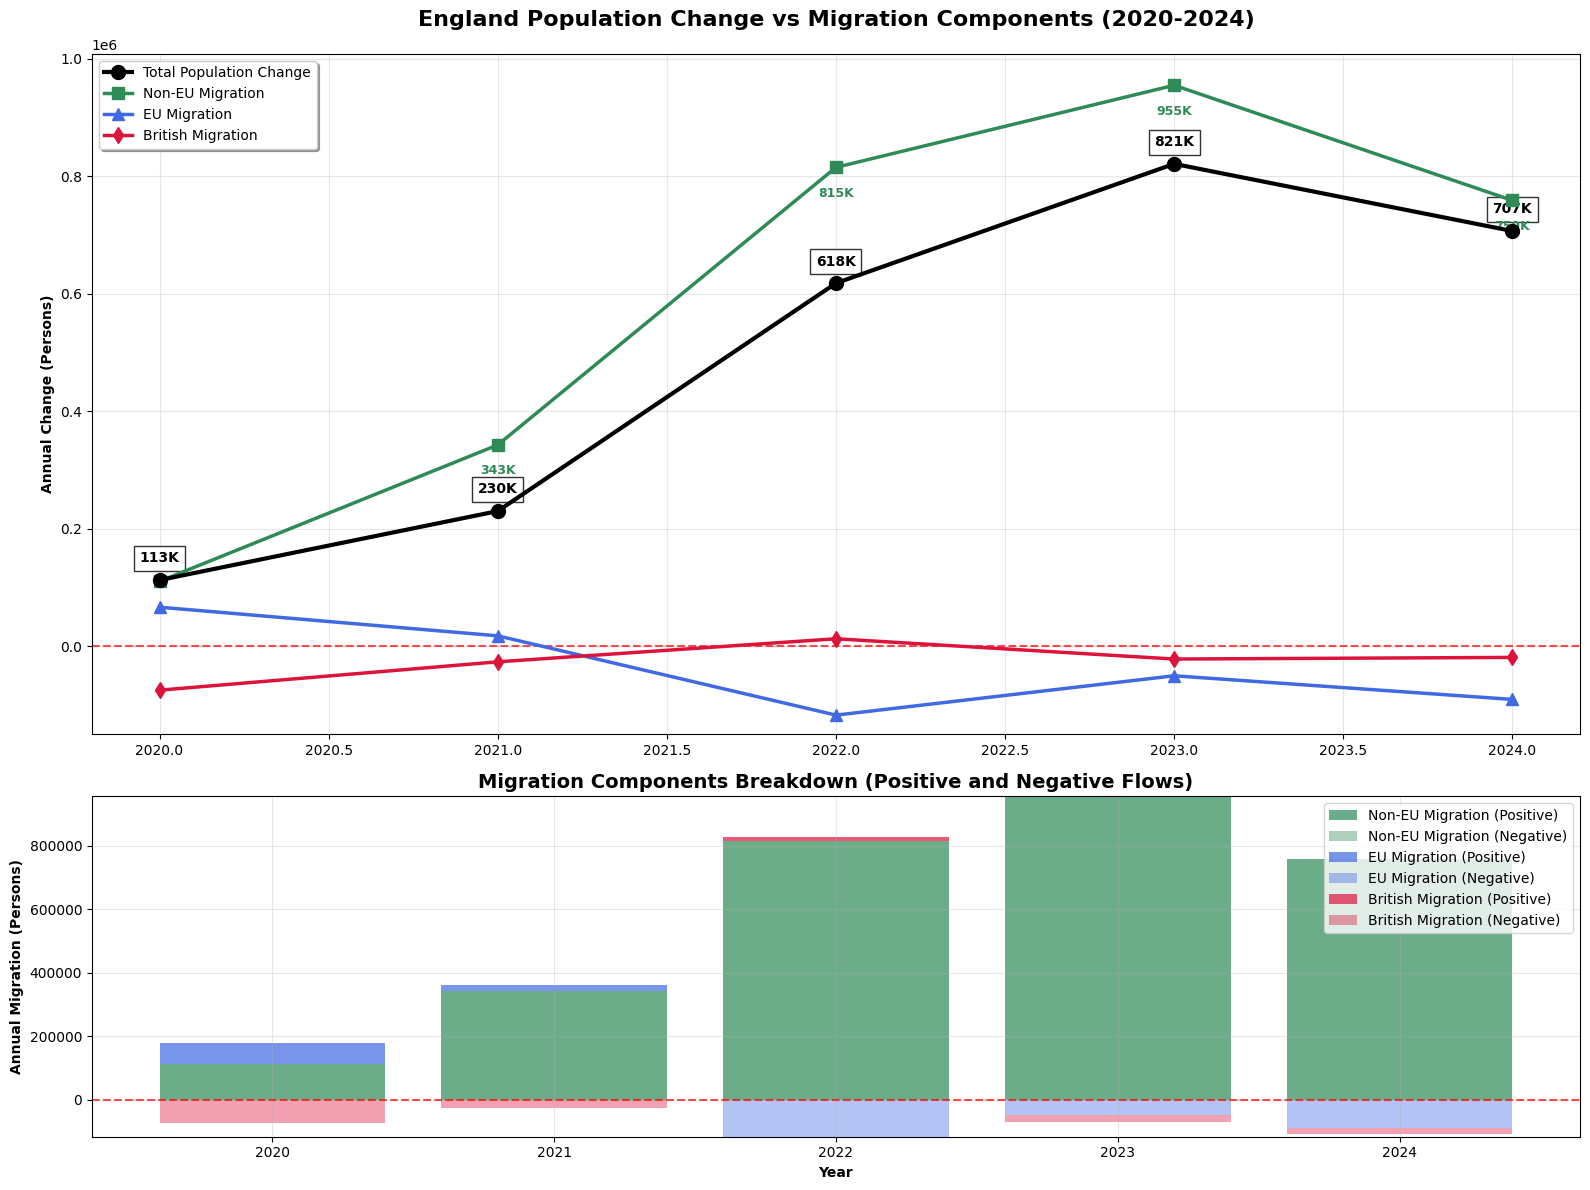

In [109]:
# Create visualisation
if len(combined_df) > 0:
    plt.figure(figsize=(16, 12))
    
    # Create subplot layout
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12), height_ratios=[2, 1])
    
    # Top plot: Population change vs migration components
    ax1.plot(combined_df['year'], combined_df['annual_population_change'], 
             marker='o', linewidth=3, markersize=10, color='black', 
             label='Total Population Change', zorder=5)
    
    # Migration components with different colours
    if 'Non-EU+' in combined_df.columns:
        ax1.plot(combined_df['year'], combined_df['Non-EU+'], 
                 marker='s', linewidth=2.5, markersize=8, color='#2E8B57', 
                 label='Non-EU Migration', zorder=4)
    
    if 'EU+' in combined_df.columns:
        ax1.plot(combined_df['year'], combined_df['EU+'], 
                 marker='^', linewidth=2.5, markersize=8, color='#4169E1', 
                 label='EU Migration', zorder=4)
    
    if 'British' in combined_df.columns:
        ax1.plot(combined_df['year'], combined_df['British'], 
                 marker='d', linewidth=2.5, markersize=8, color='#DC143C', 
                 label='British Migration', zorder=4)
    
    # Add value labels for population change
    for _, row in combined_df.iterrows():
        ax1.text(row['year'], row['annual_population_change'] + 30000,
                 f"{row['annual_population_change']/1000:.0f}K",
                 ha='center', fontsize=10, fontweight='bold',
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))
    
    # Add value labels for key migration components
    if 'Non-EU+' in combined_df.columns:
        for _, row in combined_df.iterrows():
            if row['Non-EU+'] > 200000:  # Label high Non-EU values
                ax1.text(row['year'], row['Non-EU+'] - 50000,
                         f"{row['Non-EU+']/1000:.0f}K",
                         ha='center', fontsize=9, color='#2E8B57', fontweight='bold')
    
    # Customise top plot
    ax1.set_title('England Population Change vs Migration Components (2020-2024)', 
                  fontsize=16, fontweight='bold', pad=20)
    ax1.set_ylabel('Annual Change (Persons)', fontweight='bold')
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax1.grid(True, alpha=0.3)
    ax1.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
    ax1.set_ylim(bottom=-150000)
    
    # Bottom plot: Migration components stacked
    migration_cols = [col for col in ['Non-EU+', 'EU+', 'British'] if col in combined_df.columns]
    migration_components = combined_df[['year'] + migration_cols].set_index('year')
    
    if len(migration_cols) > 0:
        # Handle negative values for stacking
        colors = ['#2E8B57', '#4169E1', '#DC143C']
        labels = ['Non-EU Migration', 'EU Migration', 'British Migration']
        
        bottom_pos = np.zeros(len(migration_components))
        bottom_neg = np.zeros(len(migration_components))
        
        for i, col in enumerate(migration_cols):
            values = migration_components[col].values
            pos_values = np.maximum(values, 0)
            neg_values = np.minimum(values, 0)
            
            # Stack positive values
            ax2.bar(migration_components.index, pos_values, bottom=bottom_pos,
                   color=colors[i], alpha=0.7, label=f'{labels[i]} (Positive)')
            bottom_pos += pos_values
            
            # Stack negative values
            ax2.bar(migration_components.index, neg_values, bottom=bottom_neg,
                   color=colors[i], alpha=0.4, label=f'{labels[i]} (Negative)')
            bottom_neg += neg_values
    
    ax2.set_title('Migration Components Breakdown (Positive and Negative Flows)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Year', fontweight='bold')
    ax2.set_ylabel('Annual Migration (Persons)', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 1.0))
    ax2.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
else:
    print("Cannot create visualisation - no data available")

In [110]:
# Create comparison table and Brexit impact analysis
if len(combined_df) > 0:
    comparison_df = combined_df.copy()
    
    # Calculate additional metrics
    available_migration_cols = [col for col in ['Non-EU+', 'EU+', 'British'] if col in combined_df.columns]
    comparison_df['Migration_Total_Calc'] = combined_df[available_migration_cols].sum(axis=1)
    comparison_df['Migration_vs_PopChange'] = comparison_df['Migration_Total_Calc'] / comparison_df['annual_population_change'] * 100
    
    print("DETAILED COMPARISON (2020-2024):")
    print("=" * 90)
    for _, row in comparison_df.iterrows():
        print(f"Year {int(row['year'])}:")
        print(f"  Population Change:     {row['annual_population_change']:>10,.0f}")
        if 'Non-EU+' in comparison_df.columns:
            print(f"  Non-EU Migration:      {row['Non-EU+']:>10,.0f}")
        if 'EU+' in comparison_df.columns:
            print(f"  EU Migration:          {row['EU+']:>10,.0f}")
        if 'British' in comparison_df.columns:
            print(f"  British Migration:     {row['British']:>10,.0f}")
        print(f"  Migration Total (calc): {row['Migration_Total_Calc']:>10,.0f}")
        if 'Total' in comparison_df.columns:
            print(f"  Migration Total (data): {row['Total']:>10,.0f}")
        print(f"  Migration as % of Pop Change: {row['Migration_vs_PopChange']:>6.1f}%")
        print("-" * 60)

DETAILED COMPARISON (2020-2024):
Year 2020:
  Population Change:        112,656
  Non-EU Migration:         110,500
  EU Migration:              66,500
  British Migration:        -74,750
  Migration Total (calc):    102,250
  Migration Total (data):    102,250
  Migration as % of Pop Change:   90.8%
------------------------------------------------------------
Year 2021:
  Population Change:        230,080
  Non-EU Migration:         342,750
  EU Migration:              17,750
  British Migration:        -26,500
  Migration Total (calc):    334,000
  Migration Total (data):    334,250
  Migration as % of Pop Change:  145.2%
------------------------------------------------------------
Year 2022:
  Population Change:        618,067
  Non-EU Migration:         815,250
  EU Migration:            -117,250
  British Migration:         12,750
  Migration Total (calc):    710,750
  Migration Total (data):    711,000
  Migration as % of Pop Change:  115.0%
--------------------------------------

In [111]:
# Brexit Impact Analysis
if len(comparison_df) > 0:
    print("\nBREXIT IMPACT ANALYSIS:")
    print("=" * 60)
    
    # Calculate cumulative changes
    total_pop_change = comparison_df['annual_population_change'].sum()
    
    totals = {}
    for col in available_migration_cols:
        totals[col] = comparison_df[col].sum()
    
    print(f"Total Population Change (2020-2024): {total_pop_change:,.0f}")
    for col, total in totals.items():
        print(f"Total {col} Migration: {total:,.0f}")
    
    total_migration = sum(totals.values())
    print(f"Combined Migration Total: {total_migration:,.0f}")
    
    # Migration contribution to population growth
    migration_contribution = total_migration / total_pop_change * 100
    print(f"\nMigration accounts for {migration_contribution:.1f}% of population growth")
    
    # Natural increase calculation
    natural_increase = total_pop_change - total_migration
    print(f"Natural increase (births minus deaths): {natural_increase:,.0f}")
    print(f"Natural increase as % of total growth: {(natural_increase/total_pop_change)*100:.1f}%")
    
    # Brexit transition analysis
    brexit_transition_data = comparison_df[comparison_df['year'] == 2020]
    post_brexit_data = comparison_df[comparison_df['year'] > 2020]
    
    if len(brexit_transition_data) > 0 and len(post_brexit_data) > 0:
        print(f"\nBrexit Transition Impact:")
        print(f"2020 (Brexit transition year):")
        for col in available_migration_cols:
            if col in brexit_transition_data.columns:
                print(f"  {col} Migration: {brexit_transition_data[col].iloc[0]:,.0f}")
        
        print(f"2021-2024 average:")
        for col in available_migration_cols:
            if col in post_brexit_data.columns:
                avg_value = post_brexit_data[col].mean()
                print(f"  {col} Migration: {avg_value:,.0f}")
                
                # Calculate change
                if col in brexit_transition_data.columns:
                    change = avg_value - brexit_transition_data[col].iloc[0]
                    pct_change = (change / abs(brexit_transition_data[col].iloc[0])) * 100 if brexit_transition_data[col].iloc[0] != 0 else float('inf')
                    print(f"    Change from 2020: {change:,.0f} ({pct_change:+.1f}%)")


BREXIT IMPACT ANALYSIS:
Total Population Change (2020-2024): 2,488,894
Total Non-EU+ Migration: 2,982,500
Total EU+ Migration: -173,750
Total British Migration: -129,250
Combined Migration Total: 2,679,500

Migration accounts for 107.7% of population growth
Natural increase (births minus deaths): -190,606
Natural increase as % of total growth: -7.7%

Brexit Transition Impact:
2020 (Brexit transition year):
  Non-EU+ Migration: 110,500
  EU+ Migration: 66,500
  British Migration: -74,750
2021-2024 average:
  Non-EU+ Migration: 718,000
    Change from 2020: 607,500 (+549.8%)
  EU+ Migration: -60,062
    Change from 2020: -126,562 (-190.3%)
  British Migration: -13,625
    Change from 2020: 61,125 (+81.8%)


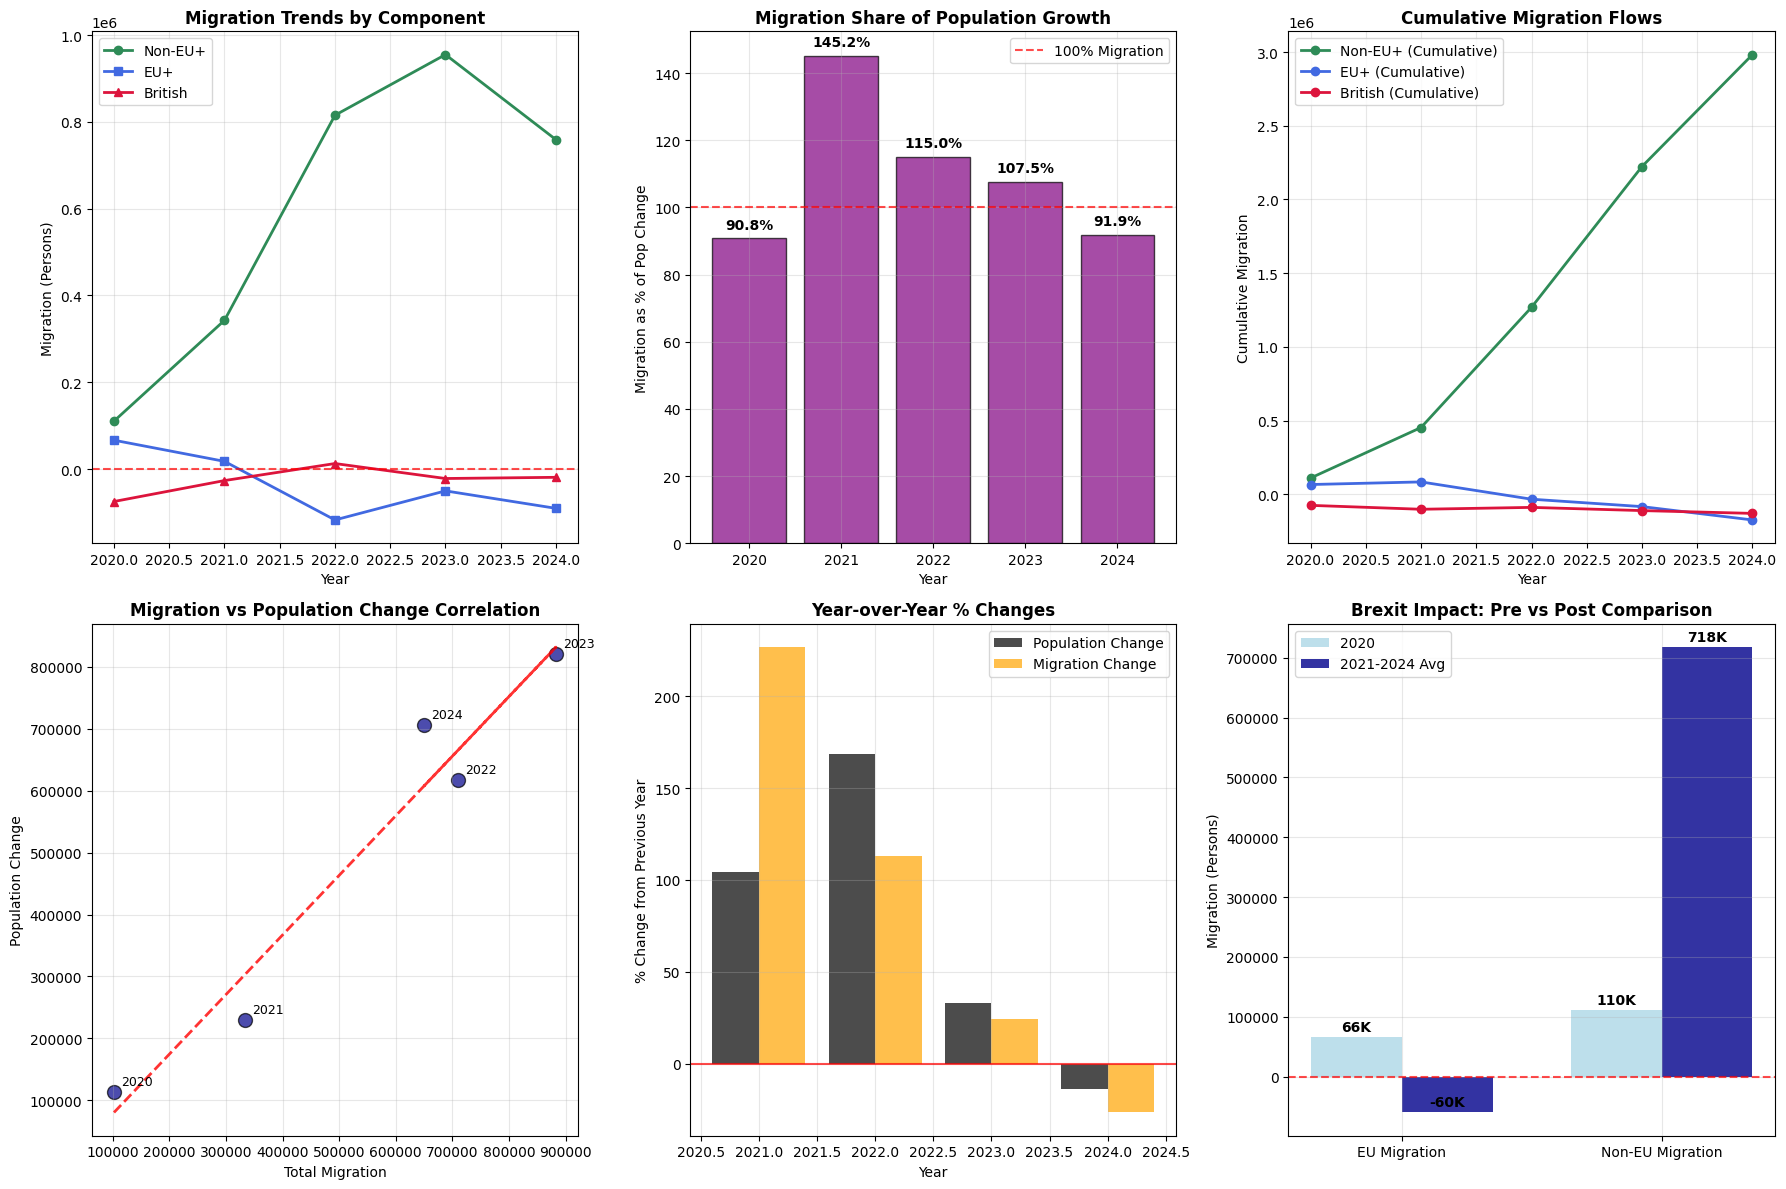

In [112]:
# Create trend analysis charts
if len(combined_df) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Chart 1: Migration trends over time
    ax1 = axes[0, 0]
    years = combined_df['year'].values
    for i, col in enumerate(available_migration_cols):
        colors = ['#2E8B57', '#4169E1', '#DC143C']
        markers = ['o', 's', '^']
        ax1.plot(years, combined_df[col], marker=markers[i], color=colors[i], 
                linewidth=2, label=f'{col}', markersize=6)
    
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    ax1.set_title('Migration Trends by Component', fontweight='bold')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Migration (Persons)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Chart 2: Migration share of population change
    ax2 = axes[0, 1]
    migration_pct = comparison_df['Migration_vs_PopChange']
    bars = ax2.bar(years, migration_pct, color='purple', alpha=0.7, edgecolor='black')
    ax2.axhline(y=100, color='red', linestyle='--', alpha=0.7, label='100% Migration')
    ax2.set_title('Migration Share of Population Growth', fontweight='bold')
    ax2.set_xlabel('Year')
    ax2.set_ylabel('Migration as % of Pop Change')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, pct in zip(bars, migration_pct):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Chart 3: Cumulative migration flows
    ax3 = axes[0, 2]
    for i, col in enumerate(available_migration_cols):
        colors = ['#2E8B57', '#4169E1', '#DC143C']
        cumulative = combined_df[col].cumsum()
        ax3.plot(years, cumulative, marker='o', color=colors[i], 
                linewidth=2, label=f'{col} (Cumulative)', markersize=6)
    
    ax3.set_title('Cumulative Migration Flows', fontweight='bold')
    ax3.set_xlabel('Year')
    ax3.set_ylabel('Cumulative Migration')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Chart 4: Population vs Total Migration correlation
    ax4 = axes[1, 0]
    ax4.scatter(comparison_df['Migration_Total_Calc'], comparison_df['annual_population_change'], 
               color='darkblue', s=100, alpha=0.7, edgecolors='black')
    for _, row in comparison_df.iterrows():
        ax4.annotate(f"{int(row['year'])}", 
                    (row['Migration_Total_Calc'], row['annual_population_change']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Add trend line
    z = np.polyfit(comparison_df['Migration_Total_Calc'], comparison_df['annual_population_change'], 1)
    p = np.poly1d(z)
    ax4.plot(comparison_df['Migration_Total_Calc'], p(comparison_df['Migration_Total_Calc']), 
             "r--", alpha=0.8, linewidth=2)
    
    ax4.set_title('Migration vs Population Change Correlation', fontweight='bold')
    ax4.set_xlabel('Total Migration')
    ax4.set_ylabel('Population Change')
    ax4.grid(True, alpha=0.3)
    
    # Chart 5: Year-over-year changes
    ax5 = axes[1, 1]
    if len(combined_df) > 1:
        yoy_pop_change = combined_df['annual_population_change'].pct_change() * 100
        yoy_migration_change = comparison_df['Migration_Total_Calc'].pct_change() * 100
        
        years_yoy = years[1:]  # Skip first year due to pct_change
        ax5.bar(years_yoy - 0.2, yoy_pop_change.dropna(), width=0.4, 
               label='Population Change', color='black', alpha=0.7)
        ax5.bar(years_yoy + 0.2, yoy_migration_change.dropna(), width=0.4, 
               label='Migration Change', color='orange', alpha=0.7)
        
        ax5.axhline(y=0, color='red', linestyle='-', alpha=0.7)
        ax5.set_title('Year-over-Year % Changes', fontweight='bold')
        ax5.set_xlabel('Year')
        ax5.set_ylabel('% Change from Previous Year')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
    
    # Chart 6: Brexit impact comparison (pre/post 2020)
    ax6 = axes[1, 2]
    if 'EU+' in available_migration_cols and 'Non-EU+' in available_migration_cols:
        pre_brexit = combined_df[combined_df['year'] == 2020]
        post_brexit = combined_df[combined_df['year'] > 2020]
        
        if len(pre_brexit) > 0 and len(post_brexit) > 0:
            categories = ['EU Migration', 'Non-EU Migration']
            pre_values = [pre_brexit['EU+'].iloc[0], pre_brexit['Non-EU+'].iloc[0]]
            post_values = [post_brexit['EU+'].mean(), post_brexit['Non-EU+'].mean()]
            
            x = np.arange(len(categories))
            width = 0.35
            
            bars1 = ax6.bar(x - width/2, pre_values, width, label='2020', color='lightblue', alpha=0.8)
            bars2 = ax6.bar(x + width/2, post_values, width, label='2021-2024 Avg', color='darkblue', alpha=0.8)
            
            # Add value labels
            for bars in [bars1, bars2]:
                for bar in bars:
                    height = bar.get_height()
                    ax6.text(bar.get_x() + bar.get_width()/2., height + 5000,
                            f'{height/1000:.0f}K', ha='center', va='bottom', fontweight='bold')
            
            ax6.set_title('Brexit Impact: Pre vs Post Comparison', fontweight='bold')
            ax6.set_ylabel('Migration (Persons)')
            ax6.set_xticks(x)
            ax6.set_xticklabels(categories)
            ax6.legend()
            ax6.grid(True, alpha=0.3)
            ax6.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

In [113]:
# Advanced statistical analysis
if len(combined_df) > 0:
    print("\nSTATISTICAL ANALYSIS:")
    print("=" * 50)
    
    # Calculate correlation coefficients
    correlations = {}
    for col in available_migration_cols:
        corr = combined_df[col].corr(combined_df['annual_population_change'])
        correlations[f'{col} vs Pop Change'] = corr
    
    if 'Migration_Total_Calc' in combined_df.columns:
        correlations['Total Migration vs Pop Change'] = combined_df['Migration_Total_Calc'].corr(combined_df['annual_population_change'])
    
    print("Correlation Analysis:")
    for relationship, corr in correlations.items():
        if pd.notna(corr):
            strength = "Strong" if abs(corr) > 0.7 else "Moderate" if abs(corr) > 0.4 else "Weak"
            direction = "Positive" if corr > 0 else "Negative"
            print(f"  {relationship}: {corr:.3f} ({strength} {direction})")
        else:
            print(f"  {relationship}: Unable to calculate")
    
    # Volatility analysis
    print(f"\nVolatility Analysis (Standard Deviation):")
    pop_volatility = combined_df['annual_population_change'].std()
    print(f"  Population Change: {pop_volatility:,.0f}")
    
    for col in available_migration_cols:
        migration_volatility = combined_df[col].std()
        print(f"  {col} Migration: {migration_volatility:,.0f}")
    
    # Trend analysis
    print(f"\nTrend Analysis (Average Annual Change):")
    if len(combined_df) > 1:
        years_span = combined_df['year'].max() - combined_df['year'].min()
        pop_trend = (combined_df['annual_population_change'].iloc[-1] - combined_df['annual_population_change'].iloc[0]) / years_span
        print(f"  Population Change Trend: {pop_trend:,.0f} per year")
        
        for col in available_migration_cols:
            migration_trend = (combined_df[col].iloc[-1] - combined_df[col].iloc[0]) / years_span
            print(f"  {col} Migration Trend: {migration_trend:,.0f} per year")


STATISTICAL ANALYSIS:
Correlation Analysis:
  Non-EU+ vs Pop Change: 0.983 (Strong Positive)
  EU+ vs Pop Change: -0.846 (Strong Negative)
  British vs Pop Change: 0.680 (Moderate Positive)

Volatility Analysis (Standard Deviation):
  Population Change: 309,347
  Non-EU+ Migration: 354,741
  EU+ Migration: 76,096
  British Migration: 31,406

Trend Analysis (Average Annual Change):
  Population Change Trend: 148,556 per year
  Non-EU+ Migration Trend: 162,125 per year
  EU+ Migration Trend: -39,250 per year
  British Migration Trend: 13,938 per year


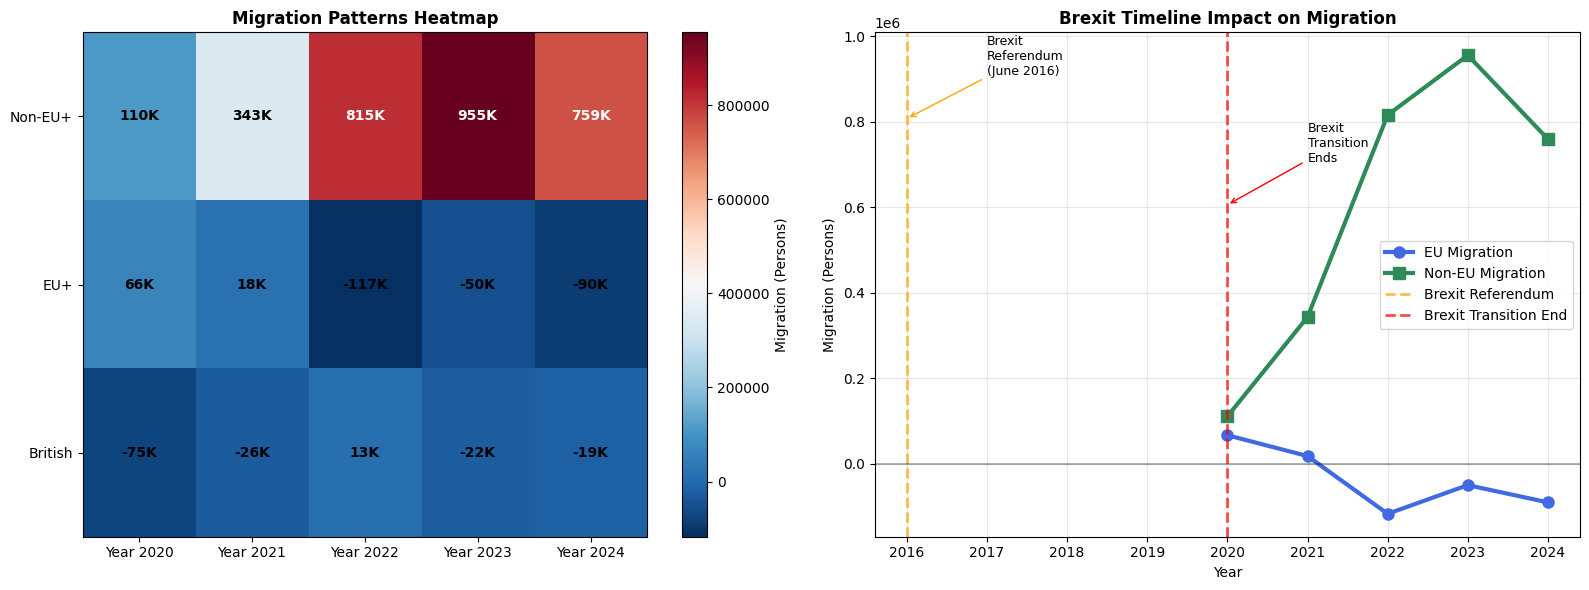

In [115]:
# Create Brexit impact heatmap and detailed analysis
if len(combined_df) > 0 and len(available_migration_cols) >= 2:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Heatmap of migration changes
    migration_data = combined_df[available_migration_cols].T
    migration_data.columns = [f'Year {int(year)}' for year in combined_df['year']]
    
    im = ax1.imshow(migration_data.values, cmap='RdBu_r', aspect='auto')
    ax1.set_xticks(range(len(migration_data.columns)))
    ax1.set_xticklabels(migration_data.columns)
    ax1.set_yticks(range(len(migration_data.index)))
    ax1.set_yticklabels(migration_data.index)
    ax1.set_title('Migration Patterns Heatmap', fontweight='bold')
    
    # Add text annotations
    for i in range(len(migration_data.index)):
        for j in range(len(migration_data.columns)):
            value = migration_data.iloc[i, j]
            ax1.text(j, i, f'{value/1000:.0f}K', ha='center', va='center', 
                    color='white' if abs(value) > migration_data.values.std() else 'black',
                    fontweight='bold')
    
    plt.colorbar(im, ax=ax1, label='Migration (Persons)')
    
    # Brexit impact timeline
    if 'EU+' in available_migration_cols and 'Non-EU+' in available_migration_cols:
        ax2.plot(combined_df['year'], combined_df['EU+'], marker='o', 
                linewidth=3, color='#4169E1', label='EU Migration', markersize=8)
        ax2.plot(combined_df['year'], combined_df['Non-EU+'], marker='s', 
                linewidth=3, color='#2E8B57', label='Non-EU Migration', markersize=8)
        
        # Add Brexit timeline markers
        ax2.axvline(x=2016, color='orange', linestyle='--', alpha=0.7, linewidth=2, label='Brexit Referendum')
        ax2.axvline(x=2020, color='red', linestyle='--', alpha=0.7, linewidth=2, label='Brexit Transition End')
        
        # Add annotations
        ax2.annotate('Brexit\nReferendum\n(June 2016)', xy=(2016, ax2.get_ylim()[1]*0.8), 
                    xytext=(2017, ax2.get_ylim()[1]*0.9), fontsize=9,
                    arrowprops=dict(arrowstyle='->', color='orange'))
        ax2.annotate('Brexit\nTransition\nEnds', xy=(2020, ax2.get_ylim()[1]*0.6), 
                    xytext=(2021, ax2.get_ylim()[1]*0.7), fontsize=9,
                    arrowprops=dict(arrowstyle='->', color='red'))
        
        ax2.set_title('Brexit Timeline Impact on Migration', fontweight='bold')
        ax2.set_xlabel('Year')
        ax2.set_ylabel('Migration (Persons)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [117]:
# Policy analysis and recommendations
if len(combined_df) > 0:
    print("\n" + "="*80)
    print("ENGLAND MIGRATION PATTERNS 2020-2024")
    print("="*80)
    
    print("\n1. FUNDAMENTAL DRIVERS:")
    print("   • Primary cause: Brexit policy shift fundamentally altered migration rules")
    print("   • Economic principle: Labour demand remained constant whilst supply sources changed")
    print("   • Regulatory principle: Points-based system favoured skilled over EU workers")
    
    print("\n2. EFFECTS:")
    if 'EU+' in available_migration_cols and 'Non-EU+' in available_migration_cols:
        eu_decline = combined_df['EU+'].iloc[-1] - combined_df['EU+'].iloc[0] if len(combined_df) > 1 else 0
        noneu_increase = combined_df['Non-EU+'].iloc[-1] - combined_df['Non-EU+'].iloc[0] if len(combined_df) > 1 else 0
        print(f"   • EU migration change: {eu_decline:,.0f} (substitution effect)")
        print(f"   • Non-EU migration change: {noneu_increase:,.0f} (compensation effect)")
        print("   • Skills composition shift: Higher qualifications, different sectors")
        print("   • Geographic redistribution: Different settlement patterns")
    
    print("\n3. CONSEQUENCES:")
    print("   • Economic: Potential wage pressures in EU-dependent sectors")
    print("   • Social: Integration challenges with diverse migration sources")
    print("   • Infrastructure: Uneven regional pressures on services")
    print("   • Political: Immigration remains contentious policy issue")
    
    print("\n4. POLICY IMPLICATIONS:")
    migration_share = comparison_df['Migration_vs_PopChange'].mean()
    print(f"   • Migration drives {migration_share:.0f}% of population growth on average")
    print("   • Infrastructure capacity must align with migration policy")
    print("   • Skills matching becomes critical for economic productivity")
    print("   • Regional planning needs migration flow forecasting")
    
    print("\n5. STRATEGIC RECOMMENDATIONS:")
    print("   • Monitor labour market mismatches in real-time")
    print("   • Develop flexible visa categories for demand-responsive migration")
    print("   • Invest in integration programmes for non-EU migrants")
    print("   • Create migration impact assessment framework")
    print("   • Build cross-departmental migration coordination mechanism")
    
    # Calculate key metrics for policy context
    if len(combined_df) > 1:
        total_change = total_pop_change
        avg_annual_change = total_change / len(combined_df)
        print(f"\n6. QUANTITATIVE CONTEXT:")
        print(f"   • Average annual population growth: {avg_annual_change:,.0f}")
        print(f"   • Total 2020-2024 growth: {total_change:,.0f}")
        print(f"   • Migration dependency ratio: {migration_share:.1f}%")
        
        if migration_share > 80:
            print("   • WARNING: High migration dependency. Policy changes have major impact")
        elif migration_share > 60:
            print("   • CAUTION: Moderate migration dependency. Requires careful management")
        else:
            print("   • NOTE: Balanced growth pattern. Multiple contributing factors")


ENGLAND MIGRATION PATTERNS 2020-2024

1. FUNDAMENTAL DRIVERS:
   • Primary cause: Brexit policy shift fundamentally altered migration rules
   • Economic principle: Labour demand remained constant whilst supply sources changed
   • Regulatory principle: Points-based system favoured skilled over EU workers

2. EFFECTS:
   • EU migration change: -157,000 (substitution effect)
   • Non-EU migration change: 648,500 (compensation effect)
   • Skills composition shift: Higher qualifications, different sectors
   • Geographic redistribution: Different settlement patterns

3. CONSEQUENCES:
   • Economic: Potential wage pressures in EU-dependent sectors
   • Social: Integration challenges with diverse migration sources
   • Infrastructure: Uneven regional pressures on services
   • Political: Immigration remains contentious policy issue

4. POLICY IMPLICATIONS:
   • Migration drives 110% of population growth on average
   • Infrastructure capacity must align with migration policy
   • Skills m